# SVM Diabetes

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
import os

# Load Data
#os.chdir("/home/pier/Machine_Learning/KE5206NN/diabetes_svm")
os.chdir("/Users/pierlim/PycharmProjects/KE5206NN/diabetes_svm")
dfs = pd.read_excel("data/diabetic_data.xlsx", sheet_name=None)
df = dfs['in'] # take out first sheet named 'in'
df.shape

(101766, 50)

## Data Exploration

### Correlation Plot (only for numeric values)

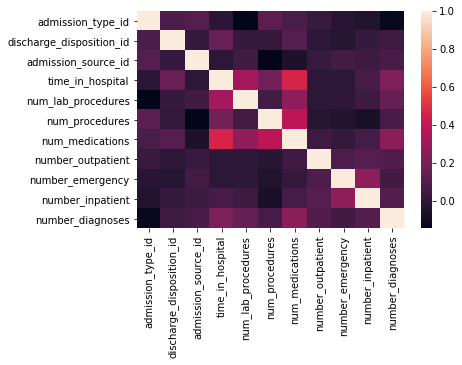

In [5]:
df = df.iloc[:, 2:] # remove encounter_id, patient_nbr
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [6]:
df.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [7]:
def show_unique(dataF):
    for c in dataF.columns:
        print(c, dataF[c].unique())
        print('*'*50)

show_unique(df)

race ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
**************************************************
gender ['Female' 'Male' 'Unknown/Invalid']
**************************************************
age ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
**************************************************
weight ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
**************************************************
admission_type_id [6 1 2 3 4 5 8 7]
**************************************************
discharge_disposition_id [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28 19
 27]
**************************************************
admission_source_id [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
**************************************************
time_in_hospital [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
****************************************

In [8]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [9]:
to_num = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
         'num_medications', 'number_outpatient', 'number_emergency',
         'number_inpatient', 'number_diagnoses']

to_cat_codes = list(set(df.columns) - set(to_num))


In [10]:
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,?,Pediatrics-Endocrinology,250.83,0,0,None,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),?,?,?,276,250.01,255,None,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),?,?,?,648,250,9,None,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),?,?,?,8,250.43,403,None,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),?,?,?,197,157,250,None,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [11]:
df = df.replace('?', np.nan)
df = df.replace('Unknown/Invalid', np.nan)
print(df.columns[df.isnull().any()])

Index(['race', 'gender', 'weight', 'payer_code', 'medical_specialty'], dtype='object')


### Drop Rows with Gender = NaN

In [12]:
#obj_df = df.select_dtypes(include=['object']).copy()
print(df.isnull().sum())
df = df.dropna(subset = ['gender']) # minimal na for gender, can drop rows
df = df.fillna({'weight':df['weight'].value_counts().index[0]}) # fill weight with the most common weight
df = df.fillna({'payer_code':'NOT_SPECIFIED', 'medical_specialty':'NOT_SPECIFIED'})
df.head()

race                         2273
gender                          3
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),[75-100),6,25,1,1,NOT_SPECIFIED,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),[75-100),1,1,7,3,NOT_SPECIFIED,NOT_SPECIFIED,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),[75-100),1,1,7,2,NOT_SPECIFIED,NOT_SPECIFIED,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),[75-100),1,1,7,2,NOT_SPECIFIED,NOT_SPECIFIED,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),[75-100),1,1,7,1,NOT_SPECIFIED,NOT_SPECIFIED,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


###  Convert Ordinal Values to Cat

In [13]:
df['age'] = df['age'].astype('category')
df['age'] = df['age'].cat.codes
df['weight'] = df['weight'].astype('category')
df['weight'] = df['weight'].cat.codes
df['readmitted'] = df['readmitted'].astype('category')
df['readmitted'] = df['readmitted'].cat.codes

### Convert Nominal Values to One-Hot

In [14]:
column_names = list(df.select_dtypes(include=['object']).columns.values)
one_hot = pd.get_dummies(df.select_dtypes(include=['object']))
df = df.drop(column_names, axis=1)
df = df.join(one_hot)

## Split and Scale the data

In [15]:
df_x = df.loc[:, df.columns != 'readmitted']
df_y = df.loc[:, df.columns == 'readmitted']
X_train, X_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

## Train LinearSVM

In [56]:
for var_c in [5, 10, 20, 30, 40, 50, 80, 100]:
    clf = LinearSVC(C=var_c, dual=False).fit(X_train, y_train)
    print("C = " + str(var_c))
    print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
    print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))

/home/pier/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C = 5
training accuracy: 0.59
test accuracy: 0.57
C = 10
training accuracy: 0.59
test accuracy: 0.57
C = 20
training accuracy: 0.59
test accuracy: 0.57
C = 30
training accuracy: 0.59
test accuracy: 0.57
C = 40
training accuracy: 0.59
test accuracy: 0.57
C = 50
training accuracy: 0.59
test accuracy: 0.57
C = 80
training accuracy: 0.59
test accuracy: 0.57
C = 100
training accuracy: 0.59
test accuracy: 0.57


In [55]:
for var_c in [10, 20, 50, 80, 100]:
    clf = LinearSVC(C=var_c, dual=False).fit(X_train, y_train)
    print("C = " + str(var_c))
    print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
    print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))

/home/pier/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C = 10
training accuracy: 0.59
test accuracy: 0.57
C = 20
training accuracy: 0.59
test accuracy: 0.57
C = 50
training accuracy: 0.59
test accuracy: 0.57
C = 80
training accuracy: 0.59
test accuracy: 0.57
C = 100
training accuracy: 0.59
test accuracy: 0.57


## Testing Polynomial Kernel

In [ ]:
# Get unscaled data again
df_x = df.loc[:, df.columns != 'readmitted']
df_y = df.loc[:, df.columns == 'readmitted']
X_train, X_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size=0.3, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X_train, y_train)
print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))

/Users/pierlim/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


...............................................................................................
Warning: using -h 0 may be faster
*.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*..................*
optimization finished, #iter = 894467
obj = -79154.995305, rho = 0.916367
nSV = 21294, nBSV = 11991
...................................................................................................................
Warning: using -h 0 may be faster
*......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*.................*
optimization finished, #iter = 665365
obj = -79224.925456, rho = 0.746238
nSV = 20465, nBSV = 12927
..............................................................*.........................*..*
optimization finished, #iter = 88652
obj = -234873.372288, rho = -6.361463
nSV = 48352, nBSV = 47034
Total nSV = 59022
[LibSVM]training accuracy: 0.58
test accuracy: 0.57


## Testing RBF Kernel

In [ ]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", MinMaxScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X_train, y_train)
print('training accuracy: {:.2f}'.format(clf.score(X_train, y_train)))
print('test accuracy: {:.2f}'.format(clf.score(X_test, y_test)))